In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pg_fitter_tools as fit
import sk_geo_tools as sk

In [4]:
%matplotlib notebook

## Camera Settings

In [5]:
focal_length = np.array([2.760529621789217e+03, 2.767014510543478e+03])
principle_point = np.array([1.914303537872458e+03, 1.596386868474348e+03])
radial_distortion = np.array([-0.2398, 0.1145])
tangential_distortion = np.array([0, 0])

## Load data from files
* Load all PMT locations
* Load image feature locations

In [6]:
all_pmt_locations = fit.read_3d_feature_locations("parameters/SK_all_PMT_locations.txt")
offset = np.array([0, 250])
image_feature_locations = {}
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/045.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/046.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/047.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/048.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/086.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/087.txt", offset=offset))
#image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/124.txt", offset=offset))
#image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/125.txt", offset=offset))
#image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/126.txt", offset=offset))
#image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/127.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/236.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/237.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/238.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/239.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/240.txt", offset=offset))

In [7]:
# swap out -25 and -00 for features in images where both exist
for im in image_feature_locations.values():
    for feat, loc in im.items():
        if feat[-2:] == "00" and feat[:-2]+"25" in im:
            tmp = loc
            im[feat] = im[feat[:-2]+"25"]
            im[feat[:-2]+"25"] = tmp

In [8]:
# choose features that appear in 2+ 
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
common_features = [f for f in feature_counts if feature_counts[f] > 1]
pmt_locations = {k: p for k, p in all_pmt_locations.items() if k in common_features}

In [9]:
# generate bolt locations from PMT locations
bolt_locations = sk.get_bolt_locations_barrel(pmt_locations)
common_bolt_locations = {k: b for k, b in bolt_locations.items() if k in common_features}
common_feature_locations = {**pmt_locations, **bolt_locations}
common_image_pmt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in pmt_locations}
    for k, i in image_feature_locations.items()}
common_image_feature_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in common_feature_locations}
    for k, i in image_feature_locations.items()}
common_image_bolt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in bolt_locations}
    for k, i in image_feature_locations.items()}
nimages = len(common_image_feature_locations)
nfeatures = len(common_feature_locations)
print(nimages, nfeatures)

11 600


## Plot seed positions for PMTs and bolts

<IPython.core.display.Javascript object>


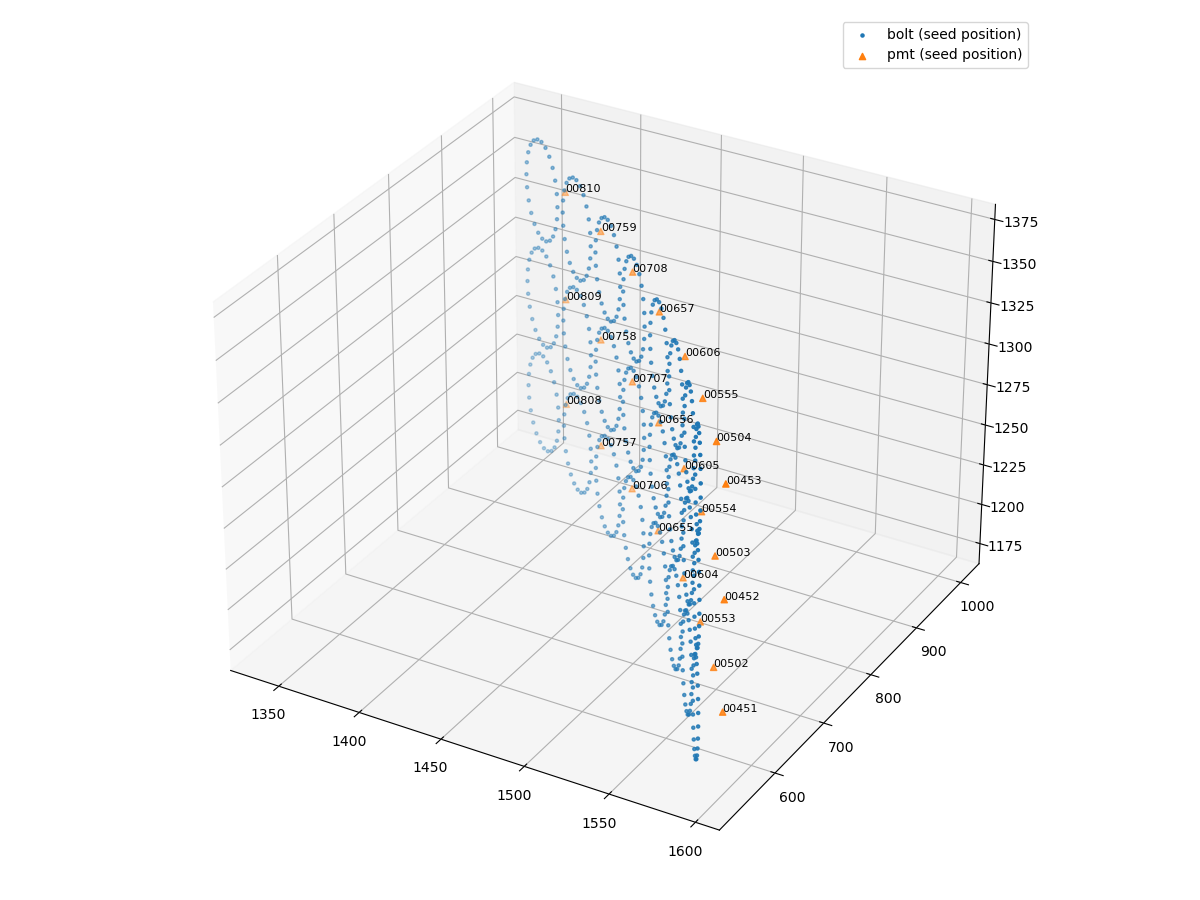

In [10]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], bolt_array[:,2], marker='.', label="bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='^', label="pmt (seed position)")
for i, f in enumerate(pmt_locations.keys()):
    ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=8, zorder=4, color='k') 
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


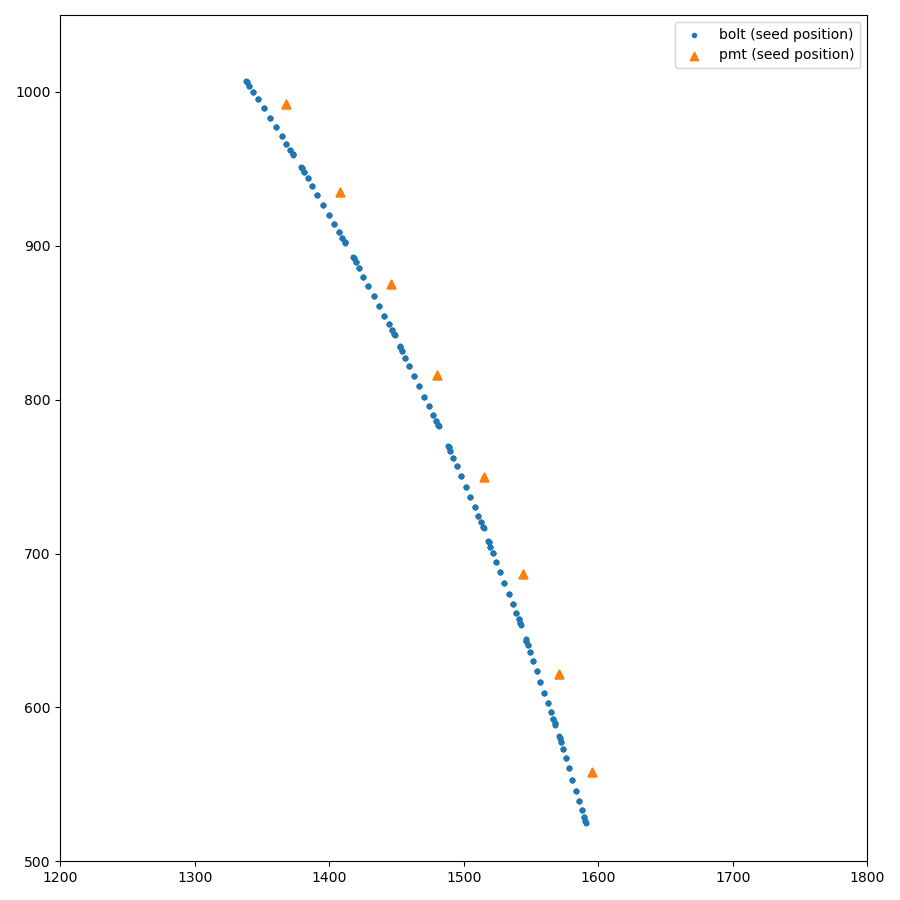

In [11]:
fig, ax = plt.subplots(figsize=(9,9))
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], marker='.', label="bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], marker='^', label="pmt (seed position)")
ax.set_ylim((500,1050))
ax.set_xlim((1200,1800))
plt.legend(loc=0)
fig.tight_layout()

## Create fitter objects

In [12]:
fitter_pmts = fit.PhotogrammetryFitter(common_image_pmt_locations, pmt_locations,
                                       focal_length, principle_point, radial_distortion)
fitter_bolts = fit.PhotogrammetryFitter(common_image_bolt_locations, common_bolt_locations,
                                       focal_length, principle_point, radial_distortion)
fitter_all = fit.PhotogrammetryFitter(common_image_feature_locations, common_feature_locations,
                                       focal_length, principle_point, radial_distortion)

11 images with total of  24 features
11 images with total of  575 features
11 images with total of  599 features



## Estimate camera poses assuming seed feature positions

In [13]:
camera_rotations, camera_translations, reprojected_points = fitter_all.estimate_camera_poses(flags=cv2.SOLVEPNP_EPNP)

image 0 reprojection errors:    average: 3.8150626073287373    max: 15.641593515365248
image 1 reprojection errors:    average: 4.533567223316524    max: 14.913212046146528
image 2 reprojection errors:    average: 4.321208830232487    max: 16.718808134953953
image 3 reprojection errors:    average: 4.495039171235897    max: 19.178706840476593
image 4 reprojection errors:    average: 3.2586080752637594    max: 13.075960879660972
image 5 reprojection errors:    average: 2.9485194138106636    max: 8.92060914864311
image 6 reprojection errors:    average: 4.061302264415295    max: 14.776616141165636
image 7 reprojection errors:    average: 3.450554259513127    max: 11.264626753206201
image 8 reprojection errors:    average: 3.17099375914385    max: 12.421395777510451
image 9 reprojection errors:    average: 2.8685487358708586    max: 8.789097469597007
image 10 reprojection errors:    average: 2.8938994243755505    max: 9.571159655795702


### Output a few of the features with largest errors for manual checking

In [14]:
max = 0
im = ""
feat = ""
im2 = ""
feat2 = ""
for i, ii in reprojected_points.items():
    for f, ff in ii.items():
        if linalg.norm(ff-image_feature_locations[i][f]) > max:
            im3 = im2
            feat3 = feat2
            im2 = im
            feat2 = feat
            im = i
            feat = f
print(im, feat, fitter_all.image_index[im])
print(im2, feat2, fitter_all.image_index[im2])
print(im3, feat3, fitter_all.image_index[im3])

240 00503-22 10
240 00605-20 10
240 00502-20 10


### Plot overlay of reprojected and observed feature locations for manual checking

<IPython.core.display.Javascript object>


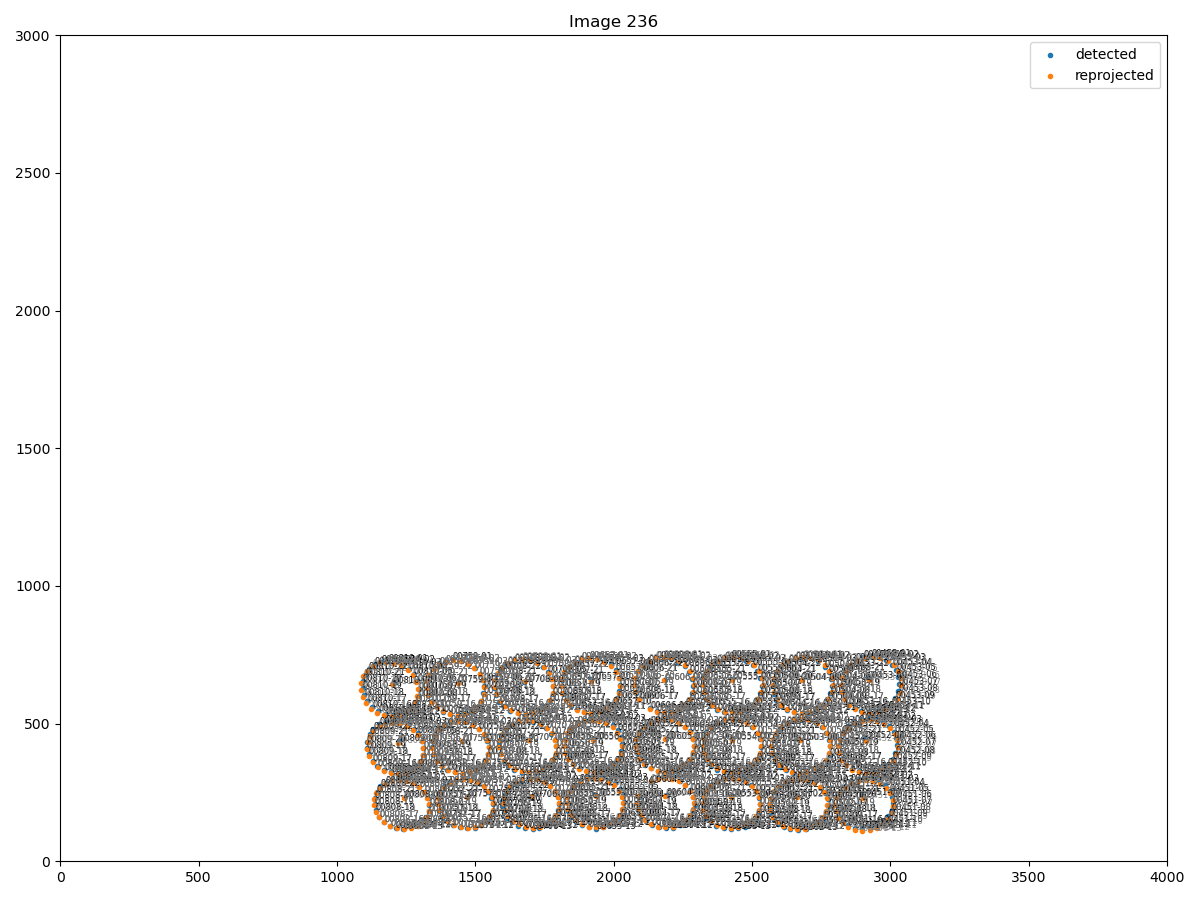

In [15]:
test_image = 6
fig, ax = plt.subplots(figsize=(12,9))
coords = np.stack(list(common_image_feature_locations[fitter_pmts.index_image[test_image]].values()))
repro_coords = np.stack(list(reprojected_points[fitter_pmts.index_image[test_image]].values()))
ax.scatter(coords[:,0], 3000-coords[:,1], marker='.', label='detected')
ax.scatter(repro_coords[:,0], 3000-repro_coords[:,1], marker='.', label='reprojected')
for t, f in common_image_feature_locations[fitter_pmts.index_image[test_image]].items():
    ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='k')
for t, f in reprojected_points[fitter_pmts.index_image[test_image]].items():
    ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='gray')
ax.set_title("Image {}".format(fitter_pmts.index_image[test_image]))
ax.set_ylim(0, 3000)
ax.set_xlim(0, 4000)
plt.legend(loc=0)
fig.tight_layout()

### Plot camera position estimates in 3D

<IPython.core.display.Javascript object>


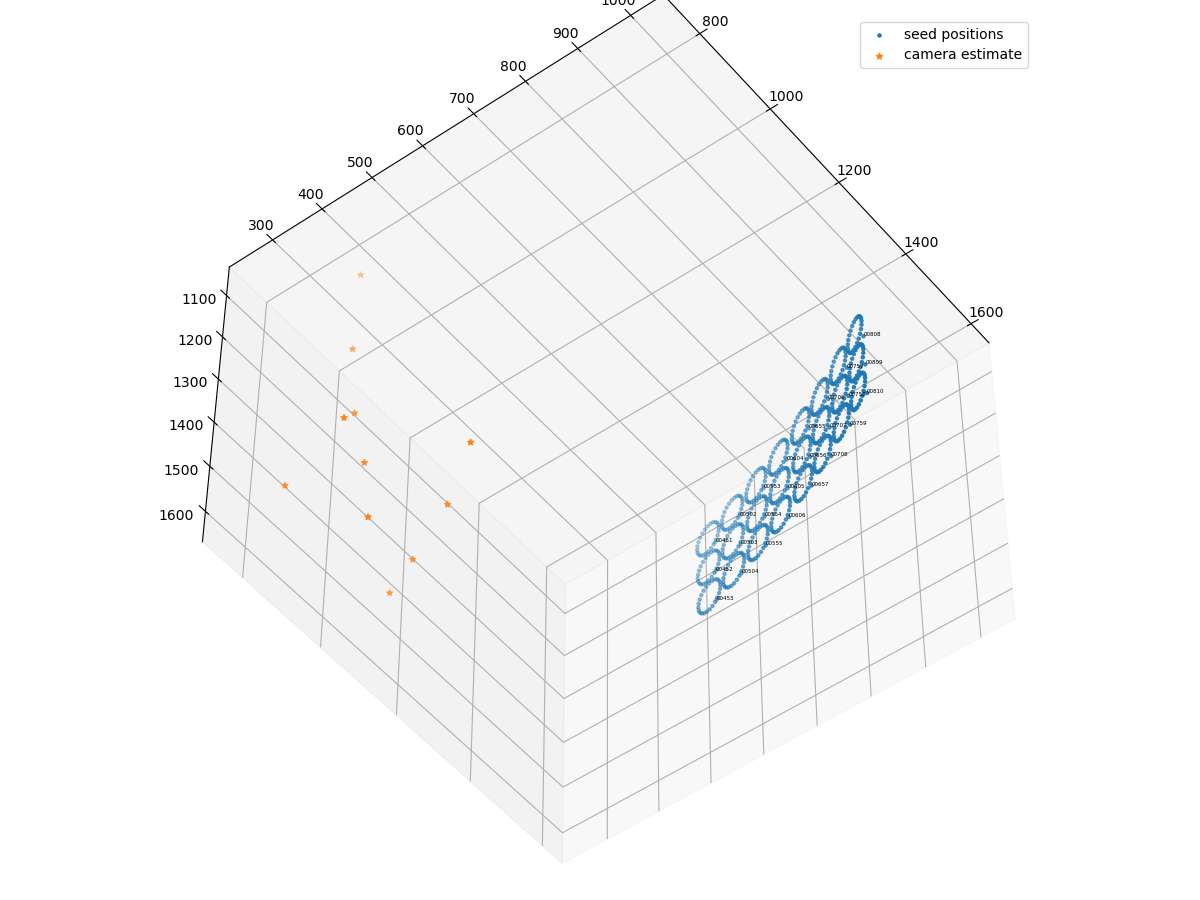

In [16]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
fig = plt.figure(figsize=(12,9))
pmt_array = np.stack(list(pmt_locations.values()))
feat_array = np.stack(list(common_feature_locations.values()))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feat_array[:,0], feat_array[:,1], feat_array[:,2], marker='.', label="seed positions", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=4, zorder=4, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera estimate", zorder=1)
plt.legend(loc=0)
fig.tight_layout()

## Perform bundle asjustment starting from seed geometry and estimated camera poses

In [17]:
camera_rotations, camera_translations, reco_locations = fitter_all.bundle_adjustment(camera_rotations, camera_translations, use_sparsity=False)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9343e+04                                    1.46e+06    
       1              6         1.9784e+04      2.96e+04       2.03e+02       1.44e+07    
       2              7         1.7240e+04      2.54e+03       2.03e+02       3.61e+06    
       3              8         9.2257e+03      8.01e+03       5.06e+01       3.09e+05    
       4             10         9.1895e+03      3.62e+01       2.53e+01       5.76e+04    
       5             12         9.1889e+03      5.54e-01       1.27e+01       5.03e+04    
       6             13         9.1886e+03      3.12e-01       1.27e+01       1.13e+04    
       7             15         9.1885e+03      7.39e-02       6.33e+00       4.01e+03    
       8             17         9.1885e+03      9.35e-03       3.16e+00       1.24e+03    
       9             19         9.1885e+03      6.37e-04       1.58e+00       3.32e+02    

## Kabsch algorithm to match reconstructed coordinate system to seed co-ordinate system

In [18]:
errors, reco_transformed, scale, R, translation, location_mean = fit.kabsch_errors(
    common_feature_locations, reco_locations)
print("mean reconstruction error:", linalg.norm(errors, axis=1).mean())
print("max reconstruction error:", linalg.norm(errors, axis=1).max())

mean reconstruction error: 1.709189639733765
max reconstruction error: 6.786836752741364


In [19]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
camera_orientations = np.matmul(R, camera_orientations)
camera_positions = camera_positions - translation
camera_positions = scale*R.dot(camera_positions.transpose()).transpose() + location_mean

## Save results to file

In [20]:
outputdir = "results/"
fileroot = "SK_demo2"

# For ROOT analysis
fitter_all.save_result(outputdir+fileroot+"_features.txt", outputdir+fileroot+"_cameras.txt")

# For Python analysis
import pickle
with open(outputdir+fileroot+'.pkl', 'wb') as output:
    pickle.dump(fitter_all, output, pickle.HIGHEST_PROTOCOL)

## Plots of reconstructed geometry

<IPython.core.display.Javascript object>


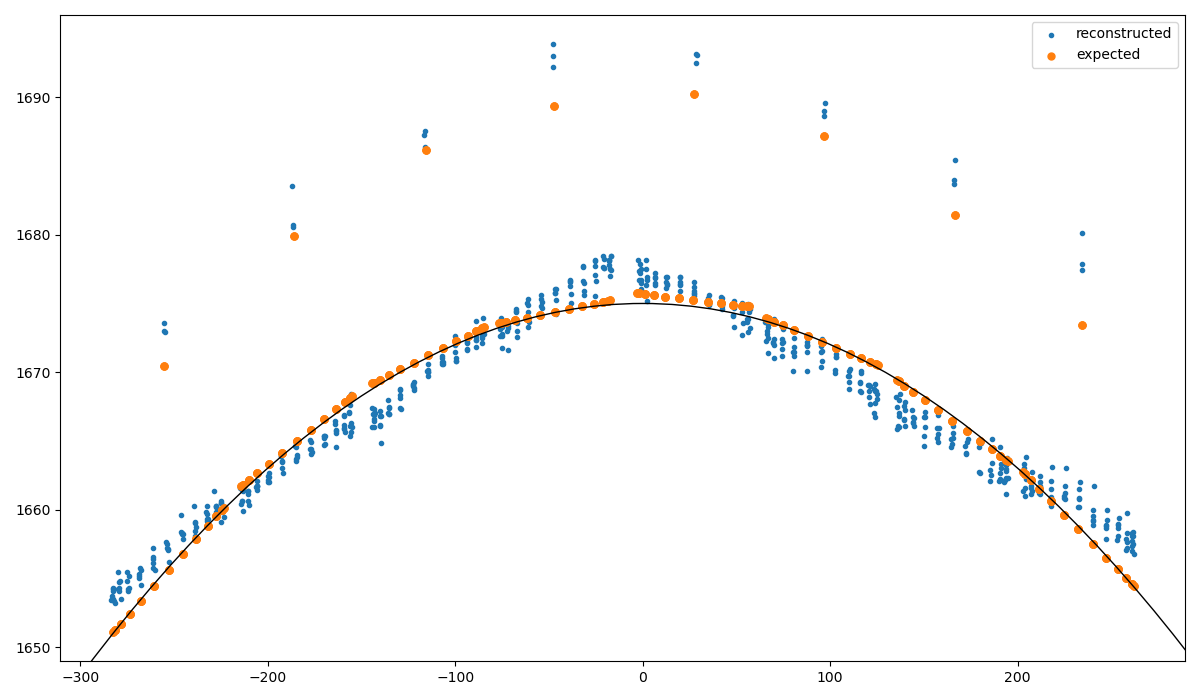

In [21]:
true_array = np.stack(list(common_feature_locations.values()))
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
rot_theta = (90-27.261)*np.pi/180
ax.scatter(reco_transformed[:,0]*np.cos(rot_theta)-reco_transformed[:,1]*np.sin(rot_theta), reco_transformed[:,0]*np.sin(rot_theta)+reco_transformed[:,1]*np.cos(rot_theta), marker='.', label="reconstructed")
ax.scatter(true_array[:,0]*np.cos(rot_theta)-true_array[:,1]*np.sin(rot_theta), true_array[:,0]*np.sin(rot_theta)+true_array[:,1]*np.cos(rot_theta), marker='.', label="expected", s=100)
#ax.set_ylim((500,1050))
#ax.set_xlim((1320,1600))
circle = plt.Circle((0, 0), 1690-15, color='black', fill=False)
ax.add_artist(circle)
#for i, f in enumerate(pmt_locations.keys()):
#    ax.text(reco_transformed[i,0], reco_transformed[i,1], f, size=4, zorder=1, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera")
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


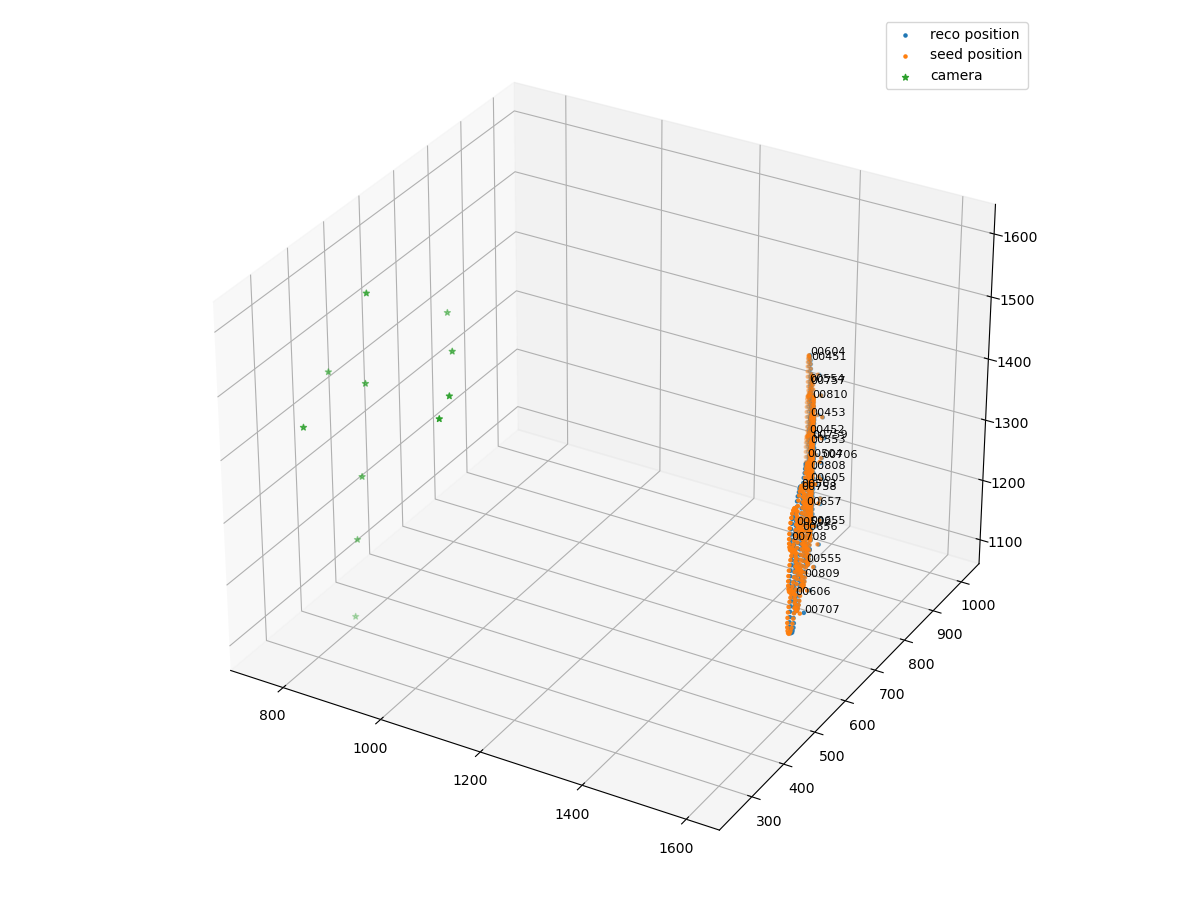

In [22]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="reco position", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="seed position", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=8, zorder=4, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


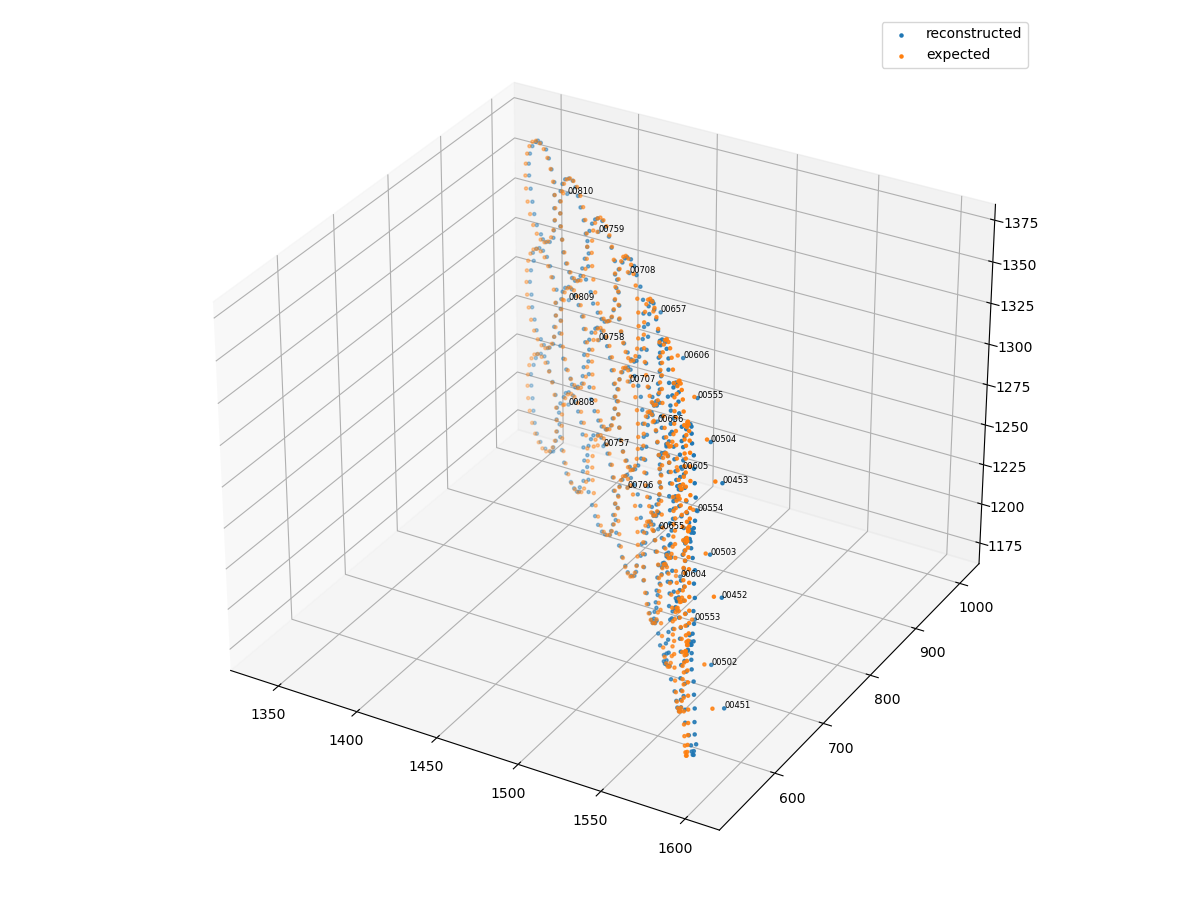

In [23]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="reconstructed", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="expected", zorder=2)
for f in pmt_locations.keys():
    i = fitter_all.feature_index[f]
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=6, zorder=4, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)
fig.tight_layout()

## Plot reprojection errors

<IPython.core.display.Javascript object>


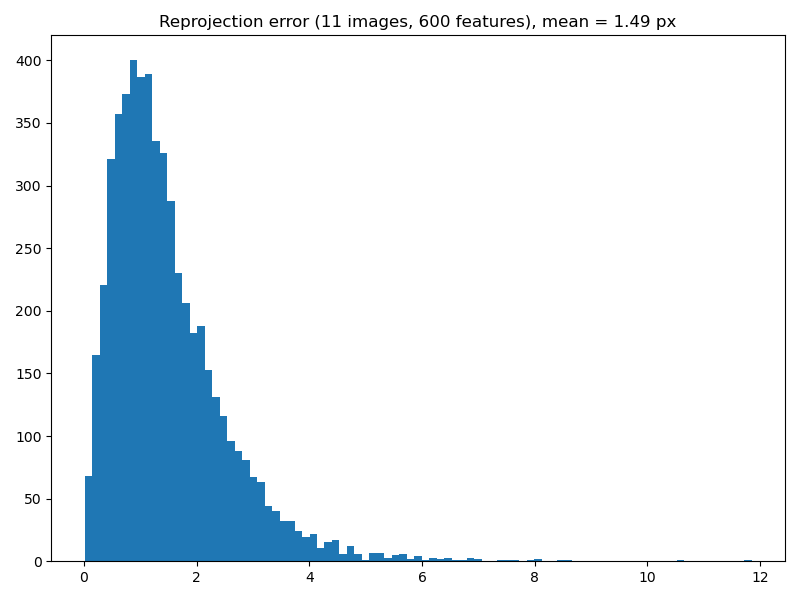

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
reprojection_errors = fitter_all.reprojection_errors(fitter_all.camera_rotations, fitter_all.camera_translations, fitter_all.reco_locations)
reprojection_errors = linalg.norm(reprojection_errors.reshape((-1,2)), axis=1)
ax.hist(reprojection_errors, bins='auto')
ax.set_title("Reprojection error ({} images, {} features), mean = {:.2f} px".format(
    nimages, nfeatures, reprojection_errors.mean()))
fig.tight_layout()

In [25]:
# Sort the images/features by highest reprojection errors, for manual checking
print(np.array(np.unravel_index(np.argsort(linalg.norm(fitter_all.reprojected_locations()-fitter_all.image_feature_locations, axis=2).ravel()), (nimages, nfeatures))))
print(linalg.norm(fitter_all.reprojected_locations()-fitter_all.image_feature_locations, axis=2)[1, 90])
print(fitter_all.index_feature[323])

[[  2   5   5 ...   8   2   1]
 [560 392 393 ...  89 385 166]]
2.6727713784873357
00453-02


## Plots of differences between expected and reconstructed geometry

<IPython.core.display.Javascript object>


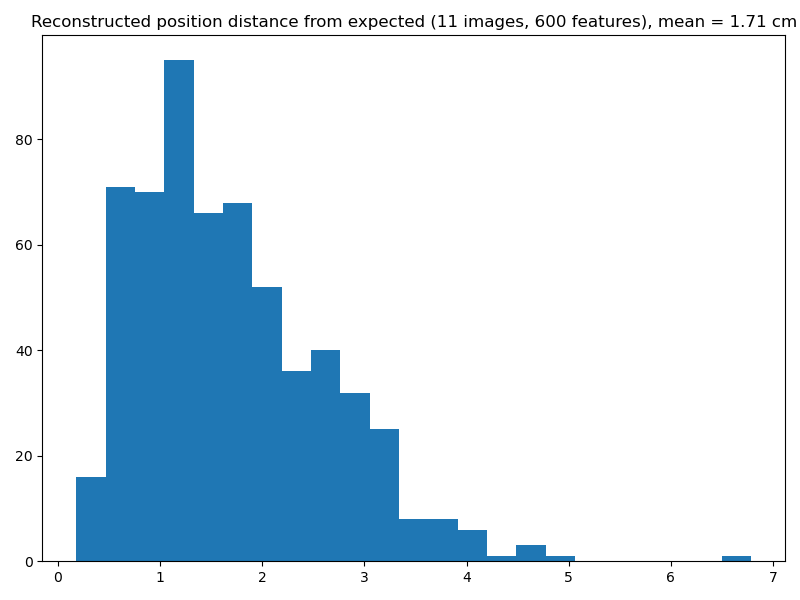

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(linalg.norm(errors, axis=1), bins='auto')
ax.set_title("Reconstructed position distance from expected ({} images, {} features), mean = {:.2f} cm".format(
    nimages, nfeatures, linalg.norm(errors, axis=1).mean()))
fig.tight_layout()

<IPython.core.display.Javascript object>


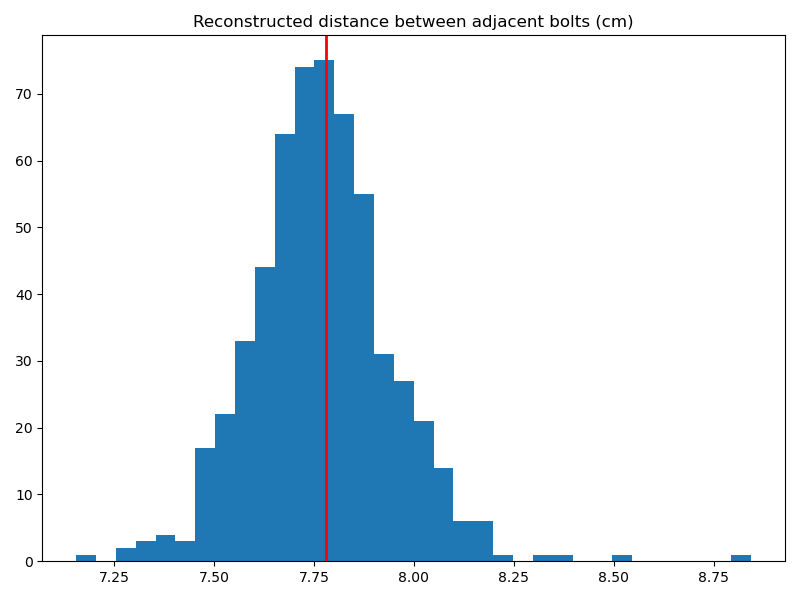

In [27]:
bolt_dict = {b: reco_transformed[fitter_all.feature_index[b]] for b in common_bolt_locations.keys()}
bolt_dists = sk.get_bolt_distances(bolt_dict)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(bolt_dists, bins='auto')
ax.set_title("Reconstructed distance between adjacent bolts (cm)")
ax.axvline(linewidth=2, color='r', x=sk.bolt_distance)
fig.tight_layout()

<IPython.core.display.Javascript object>


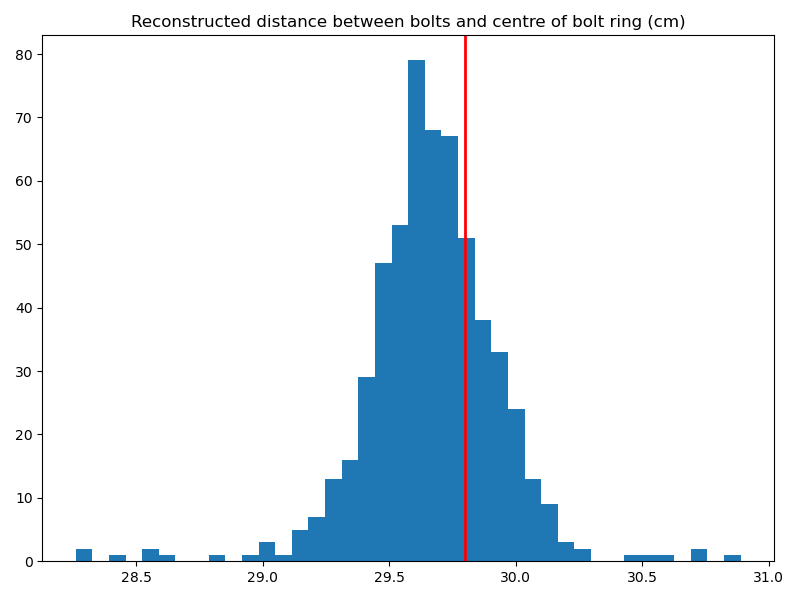

In [28]:
bolt_radii = sk.get_bolt_ring_radii(bolt_dict)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(bolt_radii, bins='auto')
ax.set_title("Reconstructed distance between bolts and centre of bolt ring (cm)")
ax.axvline(linewidth=2, color='r', x=sk.bolt_ring_radius)
fig.tight_layout()

<IPython.core.display.Javascript object>


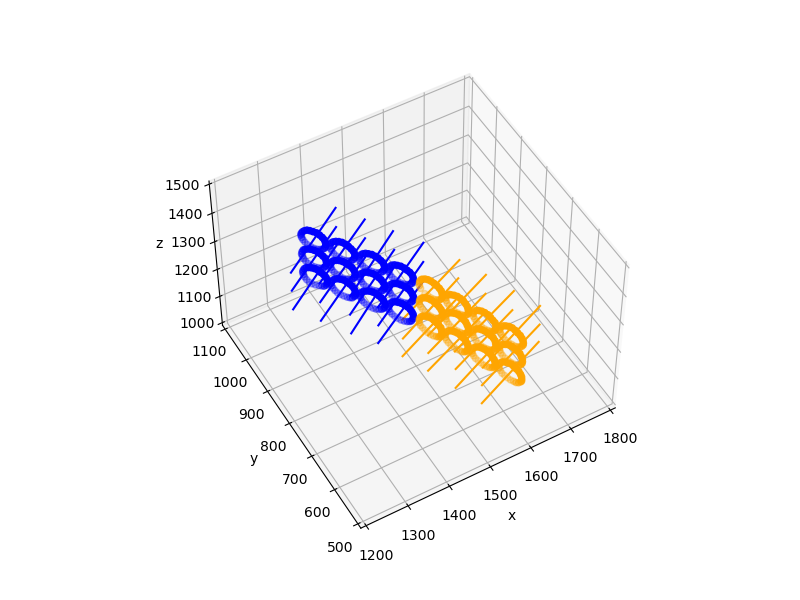

In [29]:
planes = sk.get_bolt_ring_planes(bolt_dict)
# flip planes if they're facing wrong direction (all normals should point towards tank centre)
plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')
NN = 100
for pmt in sk.get_unique_pmt_ids(bolt_dict):
    pmt_bolt_coords = np.array([l for b, l in bolt_dict.items() if b[:5] == pmt])
    icolor = 'b' if int(pmt)>607 else 'orange' 
    ax.scatter(pmt_bolt_coords[:,0], pmt_bolt_coords[:,1], pmt_bolt_coords[:,2], color=icolor)
    p, n = planes[pmt]
    X,Y,Z = [[p[i]-n[i]*NN, p[i]+n[i]*NN] for i in range(3)]
    ax.plot(X,Y,Z,color=icolor)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(1200,1800)
ax.set_ylim(500, 1100)
ax.set_zlim(1000, 1500)
ax.view_init(50, 240)

In [30]:
####### calculate the mean normal angles
###### mean normal direction of left 12 and right 12
normals1 = np.array([n for pmt, (p, n) in planes.items() if int(pmt) <= 607])
normals2 = np.array([n for pmt, (p, n) in planes.items() if int(pmt) > 607])
N1 = np.mean(normals1, axis=0)
N2 = np.mean(normals2, axis=0)
print ('norm (avg of 12 angles)', N1, N2)

##### normal for fitting all 12 at once
N1_all = sk.get_supermodule_plane(bolt_dict, 451, 606)[1]
N2_all = sk.get_supermodule_plane(bolt_dict, 655, 810)[1]
print ('norm (simultanous fit 12 PMTs)', N1_all, N2_all)

###### difference
print ('diff (degrees)', np.degrees(np.arccos(np.dot(N1, N1_all))), np.degrees(np.arccos(np.dot(N1, N2_all))))

norm (avg of 12 angles) [-9.19205090e-01 -3.93305814e-01  1.16917453e-04] [-0.83814349 -0.54508259  0.00368581]
norm (simultanous fit 12 PMTs) [-0.92096727 -0.38963011 -0.00276839] [-0.84481757 -0.53504723  0.00278088]
diff (degrees) 1.1423000158209797 9.249374220899506


In [31]:
cos1=np.dot(normals1, N1_all)
cos2=np.dot(normals2, N2_all)
theta1=np.degrees(np.arccos(cos1))
theta2=np.degrees(np.arccos(cos2))
diff_2walls = np.degrees(np.arccos(np.dot(N1_all, N2_all)))

# print (cos1)
# print (cos2)
print ('Angle between 2 walls (using normals fitted to 12 PMTs simultaneously):',diff_2walls)
print (theta1)
print (theta2)

Angle between 2 walls (using normals fitted to 12 PMTs simultaneously): 9.421031372392049
[1.35019971 0.55352472 1.50876421 0.44841582 1.02760114 1.52423556
 0.74392153 0.44933127 1.65276504 0.97194812 1.70765574 0.56977432]
[1.7167271  0.77818158 1.23735828 1.11900636 1.97960377 1.51773966
 2.20304398 1.52959808 0.52017561 0.75041251 0.31851369 0.55651664]


<IPython.core.display.Javascript object>


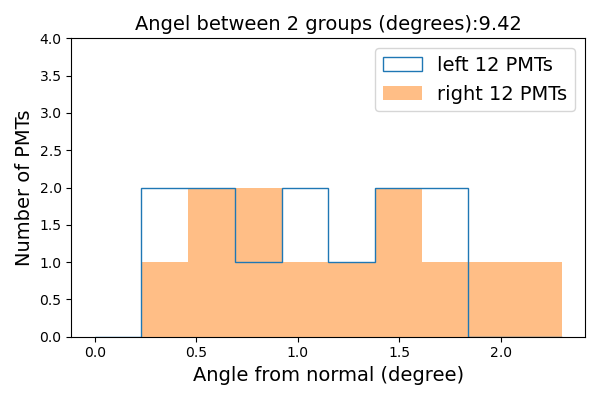

In [32]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.hist(theta1, histtype='step', bins=10, range=(0,2.3),label='left 12 PMTs')
ax.hist(theta2, histtype='stepfilled', bins=10, range=(0,2.3),label='right 12 PMTs',alpha=0.5)
ax.set_xlabel('Angle from normal (degree)', fontsize=14)
ax.set_title('Angel between 2 groups (degrees):%.2f'%(diff_2walls), fontsize=14)
ax.legend( fontsize=14)
ax.set_ylabel('Number of PMTs', fontsize=14)
ax.set_ylim(0,4)
plt.tight_layout()